In [1]:
import pandas as pd
import seaborn as sns


In [2]:
model_filter = {
    'FacEval': ['bart_large', 'co-ref bart large', 'condigsum bart large','gpt4-32k-0613','mv-bart_large', 'alpaca-13b'],
    'SAMSum': ['BART', 'CODS', 'MV-BART', 'UniLM', 'gpt4-32k-0613', 'alpaca-13b'],
    'DialogueSum': ['BART', 'CODS', 'MV-BART', 'UniLM', 'gpt4-32k-0613', 'alpaca-13b']

}
def read_filter(filename):
    df = pd.read_csv(filename)
    df_datasets = []
    unique_datasets = list(set(df['origin'].values))
    for dataset in unique_datasets: 
        df_origin = df[df['origin'] == dataset]
        df_origin = df_origin[df_origin['model'].isin(model_filter[dataset])]
        # print(len(df_origin))
        unique_docids = list(set(df_origin['docid'].values))
        #### test ###
        num_models = []
        for udocid in unique_docids:
            df_docid = df_origin[df_origin['docid'] == udocid]
            num_models.append(len(list(set(df_docid['model'].values))))
        # print(df_docid)
        # assert(len(set(num_models)) == 1) 
        df_datasets.append(df_origin)
    df_filtered = pd.concat(df_datasets)
    assert(len(df_filtered) <= len(df))
    return df_filtered


In [3]:
df = read_filter('/home/ramprasad.sa/factual_evaluation_source_based/annotations/xformer_llm_annotated.csv')
df

,Unnamed: 0,docid,model,nonfactual_spans,evidence,summary,factual_error,error_type,dialogue,origin,dialogue_atomic_facts
36,36,13730403,CODS,[],[],Tom and Camilla are going to Dublin this weekend.,0,[],Tom: Have you ever been to Dublin?\r\nCamilla:...,SAMSum,Tom asked Camilla if she has ever been to Dubl...
37,37,13730403,UniLM,[],[],Tom and Camilla decide to go to Dublin this we...,0,[],Tom: Have you ever been to Dublin?\r\nCamilla:...,SAMSum,Tom asked Camilla if she has ever been to Dubl...
38,38,13730403,BART,[],[],Tom and Camilla are going to Dublin for 2 days...,0,[],Tom: Have you ever been to Dublin?\r\nCamilla:...,SAMSum,Tom asked Camilla if she has ever been to Dubl...
39,39,13730403,MV-BART,[],[],Tom and Camilla are going to Dublin for 2 days...,0,[],Tom: Have you ever been to Dublin?\r\nCamilla:...,SAMSum,Tom asked Camilla if she has ever been to Dubl...
40,40,13730403,gpt4-32k-0613,[],[],Tom suggests to Camilla a spontaneous trip to ...,0,[],Tom: Have you ever been to Dublin?\r\nCamilla:...,SAMSum,Tom asked Camilla if she has ever been to Dubl...
...,...,...,...,...,...,...,...,...,...,...,...
2017,2017,test_352,UniLM,[],[],"person2 tells person1 the weather , the weathe...",0,[],#Person1#: Good morning.\n#Person2#: Good morn...,DialogueSum,Person1 wished person2 good morning.\nPerson2 ...
2018,2018,test_352,BART,[],[],#2# tells #Person1# the weather report and the...,0,[],#Person1#: Good morning.\n#Person2#: Good morn...,DialogueSum,Person1 wished person2 good morning.\nPerson2 ...
2019,2019,test_352,MV-BART,[],[],#Person1# and #Person2# talk about the weather...,0,[],#Person1#: Good morning.\n#Person2#: Good morn...,DialogueSum,Person1 wished person2 good morning.\nPerson2 ...
2020,2020,test_352,gpt4-32k-0613,[],[],Person 1 and Person 2 greet each other in the ...,0,[],#Person1#: Good morning.\r\n#Person2#: Good mo...,DialogueSum,Person1 wished person2 good morning.\nPerson2 ...


In [4]:
def test_no_overlap_among_datasets(df):
    print('Origin/Len/Num Docs/Num Models :')
    print('----')
    for origin in list(set(df['origin'].values)):
        df_origin = df[df['origin'] == origin]
        df_others = df[df['origin'] != origin]
        assert( len(set(df_origin['docid'].values).intersection(set(df_others['docid'].values))) == 0)
        
        print(origin, len(df_origin), len(set(df_origin['docid'])), len(set(df_others['model'].values)))
    return


def test_same_num_models_per_dataset(df):
    unique_datasets = list(set(df['origin'].values))
    for dataset in unique_datasets:
        df_origin = df[df['origin'] == dataset]
        unique_docids = list(set(df_origin['docid'].values))

        num_models = []
        for udocid in unique_docids:
            df_docid = df_origin[df_origin['docid'] == udocid]
            num_models.append(len(list(set(df_docid['model'].values))))
            # if len(list(set(df_docid['model'].values))) > 5:
            #     print(udocid)
        print(dataset, set(num_models))
        assert(len(set(num_models)) == 1) 
    

In [5]:

test_no_overlap_among_datasets(df)
test_same_num_models_per_dataset(df)

Origin/Len/Num Docs/Num Models :
----
SAMSum 474 79 10
FacEval 900 150 6
DialogueSum 576 96 10
SAMSum {6}
FacEval {6}
DialogueSum {6}


In [33]:
df_plot = {
    'dataset': [],
    'model': [],
    'factual_proportion': [],
}    
unique_datasets = list(set(df['origin'].values))
for dataset in unique_datasets:
    df_dataset = df[df['origin'] == dataset]
    unique_models = list(set(df_dataset['model'].values))
    for model in unique_models:
        df_model = df_dataset[df_dataset['model' ] == model]
        model_factual_scores = list(df_model['factual_error'].values)
        model_nonfactual_prop = model_factual_scores.count(0)/len(model_factual_scores)
        if dataset == 'DialogueSum':
            dataset = f'RefMatters (DialogSum)'
        elif dataset == 'SAMSum': 
            dataset = f'RefMatters (SAMSum)'
        elif dataset == 'FacEval':
            dataset = f'FacEval (SAMSum)'
    
        df_plot['dataset'].append(dataset)
        df_plot['model'].append(model)
        df_plot['factual_proportion'].append(model_nonfactual_prop)
        
df_plot = pd.DataFrame(df_plot)     

In [34]:
df_plot

,dataset,model,factual_proportion
0,RefMatters (SAMSum),BART,0.658228
1,RefMatters (SAMSum),UniLM,0.493671
2,RefMatters (SAMSum),alpaca-13b,0.569620
3,RefMatters (SAMSum),MV-BART,0.658228
4,RefMatters (SAMSum),CODS,0.518987
5,RefMatters (SAMSum),gpt4-32k-0613,0.784810
6,FacEval (SAMSum),mv-bart_large,0.500000
7,FacEval (SAMSum),co-ref bart large,0.546667
8,FacEval (SAMSum),alpaca-13b,0.553333
9,FacEval (SAMSum),bart_large,0.633333


In [37]:
import numpy as np
df_plot_model_category = {
'dataset': [],
'model': [],
'factual_proportion': []
}

unique_datasets = list(set(df_plot['dataset'].values))
for dataset in unique_datasets:
    print(dataset)
    df_plot_dataset = df_plot[df_plot['dataset'] == dataset ]
    factual_proportion_dataset = list(df_plot_dataset['factual_proportion'].values)
    
    llm_prop = [factual_proportion_dataset[idx] for idx, model in enumerate(list(df_plot_dataset['model'].values)) if model in ['gpt4-32k-0613', 'alpaca-13b']]
    xformer_prop = [factual_proportion_dataset[idx] for idx, model in enumerate(list(df_plot_dataset['model'].values)) if model not in ['gpt4-32k-0613', 'alpaca-13b']]
    print(dataset, llm_prop, xformer_prop, set(list(df_plot_dataset['model'].values)))
    # print(df_plot_dataset)
    
    df_plot_model_category['dataset'] += [dataset] * 2
    df_plot_model_category['model'] += ['XFORMER', 'LLM'] 
    df_plot_model_category['factual_proportion'] += [np.mean(xformer_prop), np.mean(llm_prop)]

df_plot_model_category = pd.DataFrame(df_plot_model_category)
df_plot_model_category
    

RefMatters (SAMSum)
RefMatters (SAMSum) [0.569620253164557, 0.7848101265822784] [0.6582278481012658, 0.4936708860759494, 0.6582278481012658, 0.5189873417721519] {'BART', 'UniLM', 'alpaca-13b', 'MV-BART', 'CODS', 'gpt4-32k-0613'}
FacEval (SAMSum)
FacEval (SAMSum) [0.5533333333333333, 0.7] [0.5, 0.5466666666666666, 0.6333333333333333, 0.5333333333333333] {'mv-bart_large', 'alpaca-13b', 'co-ref bart large', 'bart_large', 'condigsum bart large', 'gpt4-32k-0613'}
RefMatters (DialogSum)
RefMatters (DialogSum) [0.6666666666666666, 0.875] [0.6666666666666666, 0.6041666666666666, 0.5208333333333334, 0.6458333333333334] {'BART', 'UniLM', 'alpaca-13b', 'MV-BART', 'CODS', 'gpt4-32k-0613'}


,dataset,model,factual_proportion
0,RefMatters (SAMSum),XFORMER,0.582278
1,RefMatters (SAMSum),LLM,0.677215
2,FacEval (SAMSum),XFORMER,0.553333
3,FacEval (SAMSum),LLM,0.626667
4,RefMatters (DialogSum),XFORMER,0.609375
5,RefMatters (DialogSum),LLM,0.770833


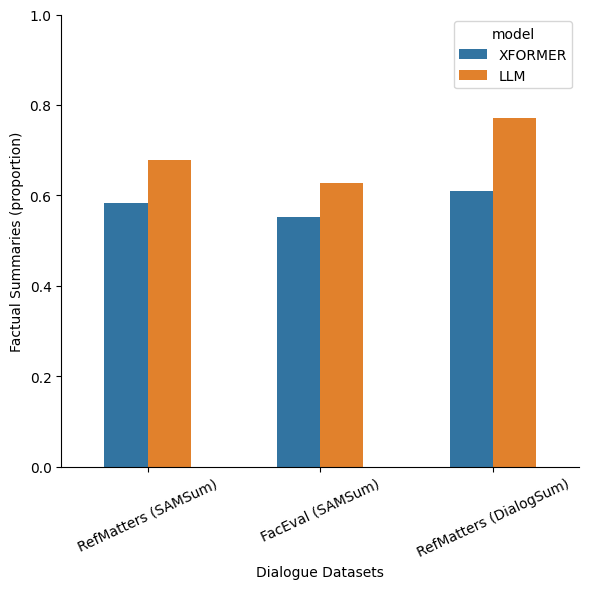

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))

ax = sns.barplot(df_plot_model_category, x = 'dataset', 
                 y = 'factual_proportion', 
                 hue = 'model', 
                  width = 0.5)ƒt
ax.set_ylim(0,1)
ax.spines[['right', 'top']].set_visible(False)
ax.set(xlabel = 'Dialogue Datasets', ylabel = 'Factual Summaries (proportion)')
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig('llm_vs_transfomrers_errors.pdf')



In [39]:
df_plot_model_category

,dataset,model,factual_proportion
0,RefMatters (SAMSum),XFORMER,0.582278
1,RefMatters (SAMSum),LLM,0.677215
2,FacEval (SAMSum),XFORMER,0.553333
3,FacEval (SAMSum),LLM,0.626667
4,RefMatters (DialogSum),XFORMER,0.609375
5,RefMatters (DialogSum),LLM,0.770833


In [40]:
df_plot['model'].values

array(['BART', 'UniLM', 'alpaca-13b', 'MV-BART', 'CODS', 'gpt4-32k-0613',
       'mv-bart_large', 'co-ref bart large', 'alpaca-13b', 'bart_large',
       'condigsum bart large', 'gpt4-32k-0613', 'BART', 'UniLM',
       'alpaca-13b', 'MV-BART', 'CODS', 'gpt4-32k-0613'], dtype=object)

In [41]:
df_plot_sorted = []

model_names = ['gpt4-32k-0613', 'alpaca-13b', 'UniLM', 'CODS', 'BART', 'MV-BART', 'condigsum bart large', 'mv-bart_large','co-ref bart large', 'bart_large']

for mname in model_names:
    df_plot_mname = df_plot[df_plot['model'] == mname]
    df_plot_sorted.append(df_plot_mname)
df_plot = pd.concat(df_plot_sorted)

In [42]:
df_plot

,dataset,model,factual_proportion
5,RefMatters (SAMSum),gpt4-32k-0613,0.784810
11,FacEval (SAMSum),gpt4-32k-0613,0.700000
17,RefMatters (DialogSum),gpt4-32k-0613,0.875000
2,RefMatters (SAMSum),alpaca-13b,0.569620
8,FacEval (SAMSum),alpaca-13b,0.553333
14,RefMatters (DialogSum),alpaca-13b,0.666667
1,RefMatters (SAMSum),UniLM,0.493671
13,RefMatters (DialogSum),UniLM,0.604167
4,RefMatters (SAMSum),CODS,0.518987
16,RefMatters (DialogSum),CODS,0.645833


In [45]:
df_plot

,dataset,model,factual_proportion
5,RefMatters (SAMSum),gpt4-32k-0613,0.784810
11,FacEval (SAMSum),gpt4-32k-0613,0.700000
17,RefMatters (DialogSum),gpt4-32k-0613,0.875000
2,RefMatters (SAMSum),alpaca-13b,0.569620
8,FacEval (SAMSum),alpaca-13b,0.553333
14,RefMatters (DialogSum),alpaca-13b,0.666667
1,RefMatters (SAMSum),UniLM,0.493671
13,RefMatters (DialogSum),UniLM,0.604167
4,RefMatters (SAMSum),CODS,0.518987
16,RefMatters (DialogSum),CODS,0.645833


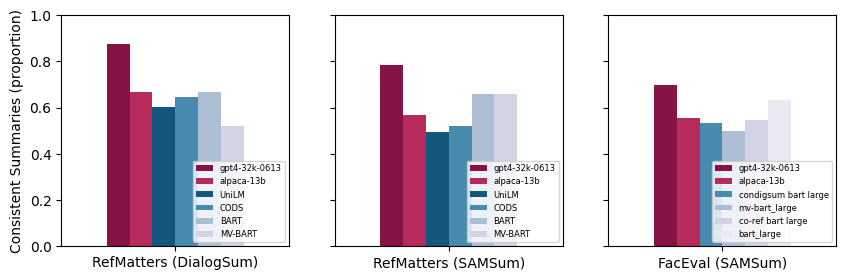

In [77]:
import seaborn as sns
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

dataset_palette = {
    'RefMatters (DialogSum)': ["#980043", "#ce1256",  "#045a8d", "#3690c0", "#a6bddb", "#d0d1e6"], 
    'RefMatters (SAMSum)': ["#980043", "#ce1256",  "#045a8d", "#3690c0", "#a6bddb", "#d0d1e6"], 
    'FacEval (SAMSum)': ["#980043", "#ce1256", "#3690c0", "#a6bddb", "#d0d1e6", "#ece7f2"]
}
# unique_datasets = list(set(df_plot['dataset'].values))
for didx, dataset in enumerate(list(dataset_palette.keys())):
    # print(dataset)
    df_plot_dataset = df_plot[df_plot['dataset'].isin([dataset])]
    gfg = sns.barplot(df_plot_dataset, 
                x = 'dataset', 
                y = 'factual_proportion', 
                hue = 'model', 
                ax = axs[didx],
                palette = dataset_palette[dataset],
                width = 0.6)
    gfg.legend(fontsize=6, loc = "lower right")
    # axs[didx].set_ylim(0,1)
    axs[didx].set(xlabel = '', ylabel = 'Consistent Summaries (proportion)')
plt.setp(axs, ylim=(0,1))
plt.savefig('llm_vs_transfomrers_errors_prop.pdf')

In [52]:
df.head()

,Unnamed: 0,docid,model,nonfactual_spans,evidence,summary,factual_error,error_type,dialogue,origin,dialogue_atomic_facts
36,36,13730403,CODS,[],[],Tom and Camilla are going to Dublin this weekend.,0,[],Tom: Have you ever been to Dublin?\r\nCamilla:...,SAMSum,Tom asked Camilla if she has ever been to Dubl...
37,37,13730403,UniLM,[],[],Tom and Camilla decide to go to Dublin this we...,0,[],Tom: Have you ever been to Dublin?\r\nCamilla:...,SAMSum,Tom asked Camilla if she has ever been to Dubl...
38,38,13730403,BART,[],[],Tom and Camilla are going to Dublin for 2 days...,0,[],Tom: Have you ever been to Dublin?\r\nCamilla:...,SAMSum,Tom asked Camilla if she has ever been to Dubl...
39,39,13730403,MV-BART,[],[],Tom and Camilla are going to Dublin for 2 days...,0,[],Tom: Have you ever been to Dublin?\r\nCamilla:...,SAMSum,Tom asked Camilla if she has ever been to Dubl...
40,40,13730403,gpt4-32k-0613,[],[],Tom suggests to Camilla a spontaneous trip to ...,0,[],Tom: Have you ever been to Dublin?\r\nCamilla:...,SAMSum,Tom asked Camilla if she has ever been to Dubl...


In [57]:
df_error_category = {
    'Category': [],
    'Dataset': []
}

def add_df(df_dataset):
    df_dataset_errors = df_dataset[df_dataset['factual_error'] == 1]
    all_error_types = list(df_dataset_errors['error_type'].values)
    all_errors_types = [each for errtype in all_error_types for each in eval(errtype)]
    # print(set(all_errors_types))
    for err_type in ['Intrinsic_Error', 'Extrinsic_Error']:
        if err_type not in df_error_category:
            df_error_category[err_type] = []
        err_type_prop = all_errors_types.count(err_type)/len(all_errors_types)
        df_error_category[err_type].append(err_type_prop)
    return

index_val = []
datasets = ['DialogueSum', 'SAMSum', 'FacEval']
for dataset in datasets:
    df_dataset = df[df['origin'] == dataset]
    df_dataset_llm = df_dataset[df_dataset['model'].isin(['gpt4-32k-0613', 'alpaca-13b'])]
    df_dataset_xformer = df_dataset[~df_dataset['model'].isin(['gpt4-32k-0613', 'alpaca-13b'])]
    add_df(df_dataset_xformer)
    if dataset == 'DialogueSum':
            dataset = f'RefMatters (DialogSum)'
    elif dataset == 'SAMSum': 
            dataset = f'RefMatters (SAMSum)'
    elif dataset == 'FacEval':
            dataset = f'FacEval (SAMSum)'
    df_error_category['Category'].append('XFORMER')
    df_error_category['Dataset'].append(f'{dataset}')
    
    add_df(df_dataset_llm)
    df_error_category['Category'].append('LLM')
    df_error_category['Dataset'].append(f'{dataset}')

    
df_error_category

{'Category': ['XFORMER', 'LLM', 'XFORMER', 'LLM', 'XFORMER', 'LLM'],
 'Dataset': ['RefMatters (DialogSum)',
  'RefMatters (DialogSum)',
  'RefMatters (SAMSum)',
  'RefMatters (SAMSum)',
  'FacEval (SAMSum)',
  'FacEval (SAMSum)'],
 'Intrinsic_Error': [0.9484536082474226,
  0.8,
  0.9141104294478528,
  0.5303030303030303,
  0.9559471365638766,
  0.46258503401360546],
 'Extrinsic_Error': [0.05154639175257732,
  0.2,
  0.08588957055214724,
  0.4696969696969697,
  0.04405286343612335,
  0.5374149659863946]}

In [58]:
df_error_category

{'Category': ['XFORMER', 'LLM', 'XFORMER', 'LLM', 'XFORMER', 'LLM'],
 'Dataset': ['RefMatters (DialogSum)',
  'RefMatters (DialogSum)',
  'RefMatters (SAMSum)',
  'RefMatters (SAMSum)',
  'FacEval (SAMSum)',
  'FacEval (SAMSum)'],
 'Intrinsic_Error': [0.9484536082474226,
  0.8,
  0.9141104294478528,
  0.5303030303030303,
  0.9559471365638766,
  0.46258503401360546],
 'Extrinsic_Error': [0.05154639175257732,
  0.2,
  0.08588957055214724,
  0.4696969696969697,
  0.04405286343612335,
  0.5374149659863946]}

In [59]:
df_error_category = pd.DataFrame(df_error_category)
df_error_category

,Category,Dataset,Intrinsic_Error,Extrinsic_Error
0,XFORMER,RefMatters (DialogSum),0.948454,0.051546
1,LLM,RefMatters (DialogSum),0.800000,0.200000
2,XFORMER,RefMatters (SAMSum),0.914110,0.085890
3,LLM,RefMatters (SAMSum),0.530303,0.469697
4,XFORMER,FacEval (SAMSum),0.955947,0.044053
5,LLM,FacEval (SAMSum),0.462585,0.537415


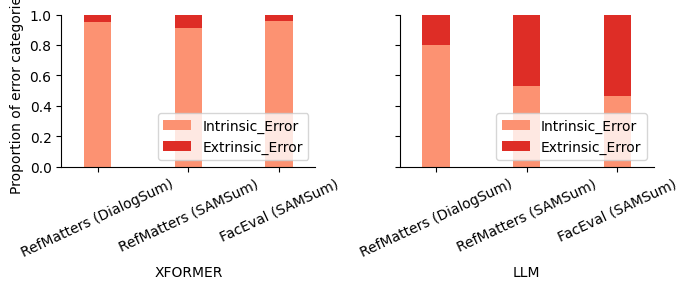

In [78]:
import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(7,3), sharey=True)

for cid, category in enumerate(['XFORMER', 'LLM']):

    df_category = df_error_category[df_error_category['Category'].isin([category])]
    df_category.plot(ax = axs[cid],
                              kind='bar', 
                             stacked=True, 
                             width = 0.3,
                             color=[ '#fc9272','#de2d26'])
    # axs[cid].set_title(category, x=0.5, y=1, fontsize = 10)
    axs[cid].spines[['right', 'top', ]].set_visible(False)
    axs[cid].set_xticklabels(labels = list(df_category['Dataset'].values),rotation=25)
    axs[cid].legend(loc = 'lower right')
    axs[cid].set(xlabel = category, 
                  ylabel = 'Proportion of error categories')

plt.setp(axs, ylim=(0,1))
plt.tight_layout()
plt.savefig('llm_vs_transformers_errors_categories.pdf')

<Figure size 1000x300 with 0 Axes>

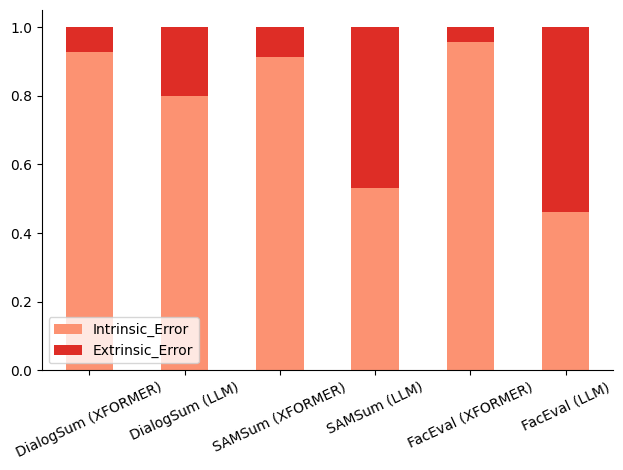

In [95]:

plt.figure(figsize=(10,3))
ax = df_error_category.plot(kind='bar', stacked=True, color=[ '#fc9272','#de2d26'])
ax.spines[['right', 'top']].set_visible(False)

plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig('llm_vs_transfomrers_errors_categories.pdf')